<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/train_explainer_experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Instrumentation Toolkit: Train Explainer - experiment #1

Extension of original Train Explainer docs looking at trying to dig deeper to identify the direct cause of zero gradients.

In [1]:
# Install Training Instrumentation Toolkit
import os
import sys
if not os.path.isdir('training-instrumentation-toolkit'):
  !git clone https://github.com/malcolmlett/training-instrumentation-toolkit.git
sys.path.append('training-instrumentation-toolkit')

# Imports
import train_instrumentation as tinstr
import train_explainer as texpl
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets

# Run some unit tests
# (no formal packaging in the toolkit as yet, so just a rudimentary manual execution of tests)
import train_instrumentation_test
import train_explainer_test
import matmul_explainer_test
import conv_tools_test
train_instrumentation_test.run_test_suite()
conv_tools_test.run_test_suite()
matmul_explainer_test.run_test_suite()
train_explainer_test.run_test_suite()

Cloning into 'training-instrumentation-toolkit'...
remote: Enumerating objects: 1372, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 1372 (delta 73), reused 45 (delta 22), pack-reused 1239 (from 1)
Receiving objects: 100% (1372/1372), 98.65 MiB | 24.26 MiB/s, done.
Resolving deltas: 100% (822/822), done.
All train_observability_toolkit tests passed.
All conv_tools tests passed.
All matmul_explainer tests passed.
All train_explainer tests passed.


## Motivation: Zero and Near-zero Gradients
While training a network, sometimes some of the unit gradients become zero. This isn't a problem if a small number are zero, but it becomes a problem when many are. When that does occur, a common practice is to guess what the cause is and to try out various documented methods to attempt to overcome the problem.

It would be much better if we can directly measure the cause of the zero gradients, as that should help us find a solution more quickly and more accurately.

Additionally, zero gradients don't suddenly happen; they are usually the culmination of less obvious problems that began to occur earlier in training. Observing and analysing _near-zero_ gradients can also help us.

There are many different ways in which gradients at a given layer can become zero, including but not limited to:
* the layer's pre-activation output values were largely negative, resulting in the ReLU activation producing many zero gradients.
* the layer's weights have all become tiny, resulting in zero or near-zero pre-activation outputs, perhaps due to a faulty loss function
* the layer's weights contain a balance of positive and negative, but in such a way that they cancel out
* the gradients in a later layer have collapsed, resulting in zero gradients being distributed to all earlier layers
* the model is misconfigured such that the layer doesn't contribute to the final model output and thus gradients don't flow back to the layer.

The first insight is that we could rule out some of the possibilities if we could directly measure some of the important quantities like the layer inputs, its weights and biases, its pre-activation outputs, its post-activation outputs, and the backward pass gradients coming back from the next layer.

The second insight is that we can determine between some of the more subtle possibilities by classifying the per-element values of weights, gradients, etc. into just 3 classes: those that are positive, those that are negative, and those that are zero or near-zero.

The `train_explainer` module does all of that, and presents the results in a short text report.

## Instrumented Training Run
For this we'll need some real data from a training run. The `train_explainer` requires that we collect raw variable tensor data for the layer in question and also a little from its input layers:
* variables, gradients, outputs, output-gradients for target layer
* outputs for input layers

We'll train a model for a simple binary classification against the well known 'circles' dataset. This is the same setup used in the other doc notebooks. In particular, if you've gone through the _Visualisations_ notebook, you might have noticed that the second layer ended with around 60% dead neurons after 1000 epochs. Let's investigate that.

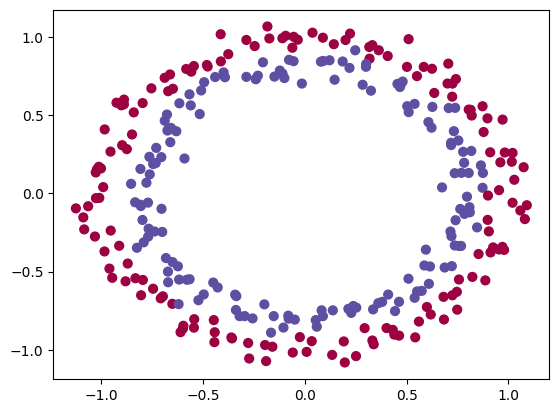

In [2]:
def binary_classification_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')
  ])
  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  return train_X, train_Y

train_X, train_Y = binary_classification_dataset()
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [3]:
# pick layer for detailed investigation
target_layer_idx = 1

# configule data collection as needed for the train_explainer
# (see train_explainer pydocs for details)
variables = tinstr.VariableHistoryCallback(collection_sets=[{'layer_indices': [target_layer_idx]}], before_updates=True)
gradients = tinstr.GradientHistoryCallback(collection_sets=[{'layer_indices': [target_layer_idx]}])
outputs = tinstr.LayerOutputHistoryCallback(collection_sets=[{'layer_indices': [target_layer_idx-1, target_layer_idx]}], batch_reduction=None)
output_gradients = tinstr.LayerOutputGradientHistoryCallback(collection_sets=[{'layer_indices': [target_layer_idx]}], batch_reduction=None)

model = binary_classification_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])
train_X, train_Y = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(32)
history = tinstr.fit(model, dataset, epochs=1000, verbose=0, callbacks=[tinstr.LessVerboseProgressLogger(), variables, gradients, outputs, output_gradients, tinstr.HistoryStats()])

# PS: any tf.function retracing warnings can be safely ignored.

Epoch   100 - 363.78ms/epoch: accuracy: 0.9467  loss: 0.1593  mse: 0.0418  
Epoch   200 - 211.50ms/epoch: accuracy: 0.9533  loss: 0.0999  mse: 0.0319  
Epoch   300 - 218.41ms/epoch: accuracy: 0.9933  loss: 0.0295  mse: 0.0071  
Epoch   400 - 219.75ms/epoch: accuracy: 0.9867  loss: 0.0296  mse: 0.0095  
Epoch   500 - 212.41ms/epoch: accuracy: 0.9867  loss: 0.0261  mse: 0.0078  
Epoch   600 - 214.63ms/epoch: accuracy: 1.0000  loss: 0.0067  mse: 0.0011  
Epoch   700 - 207.08ms/epoch: accuracy: 0.9967  loss: 0.0129  mse: 0.0030  
Epoch   800 - 202.13ms/epoch: accuracy: 0.9900  loss: 0.0315  mse: 0.0088  
Epoch   900 - 253.78ms/epoch: accuracy: 0.9800  loss: 0.0363  mse: 0.0116  
Epoch  1000 - 235.81ms/epoch: accuracy: 0.9967  loss: 0.0079  mse: 0.0021  


First, let's confirm that there's a problem and narrow down its location...

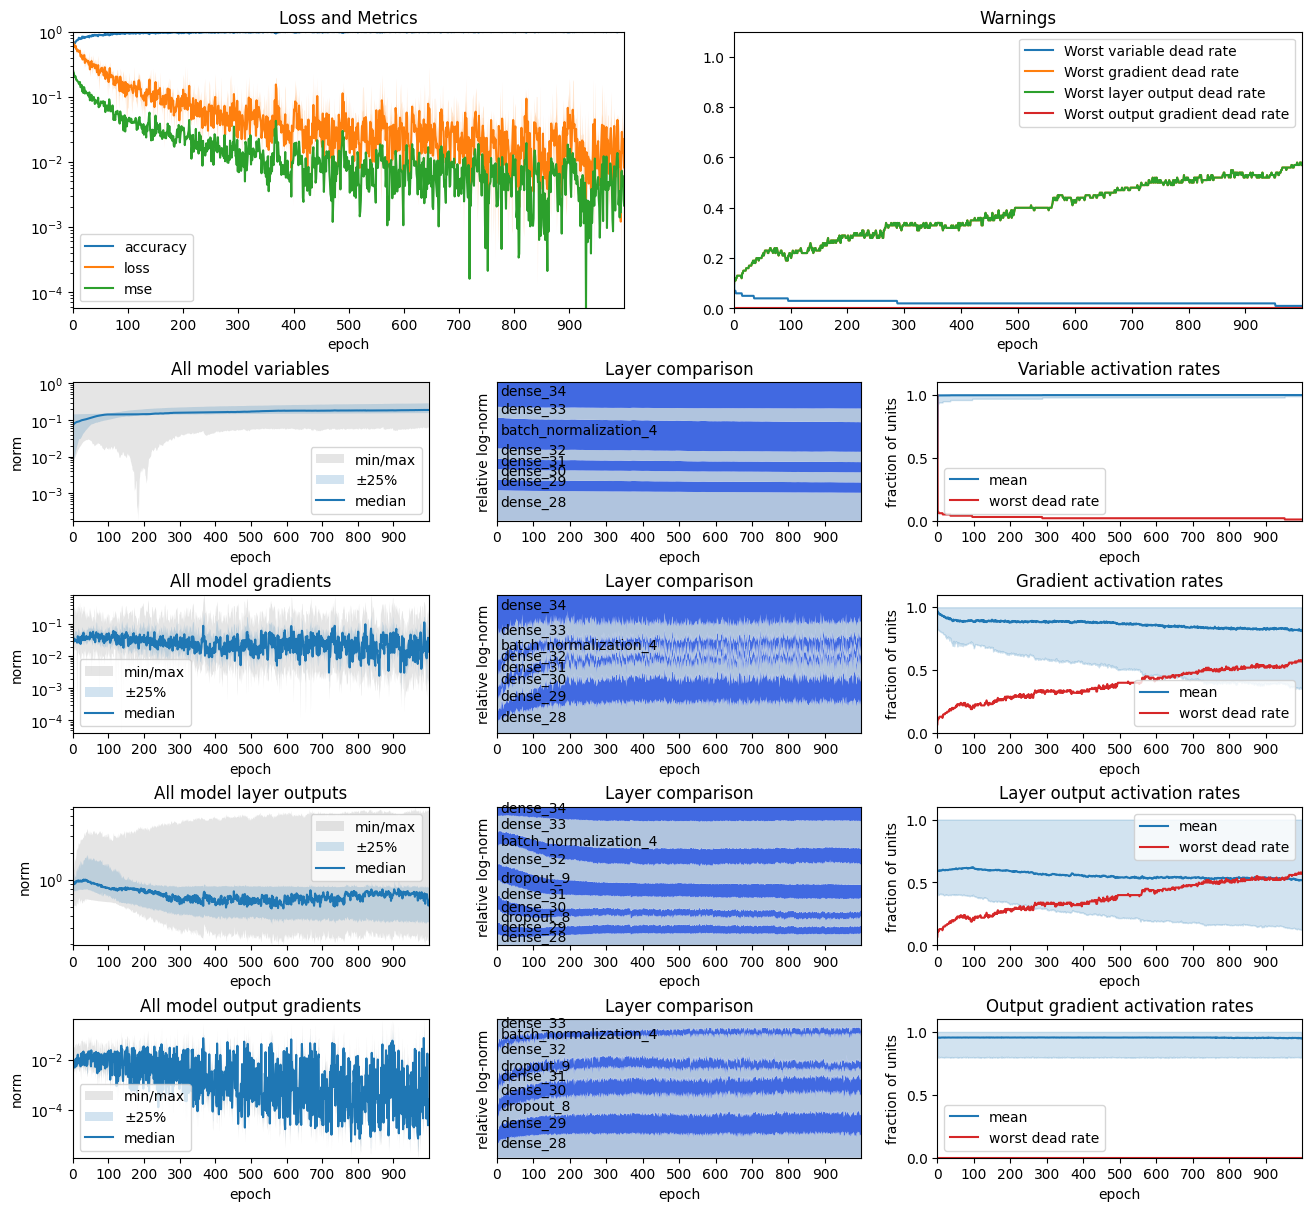

In [4]:
tinstr.plot_history_overview([history, variables, gradients, outputs, output_gradients])

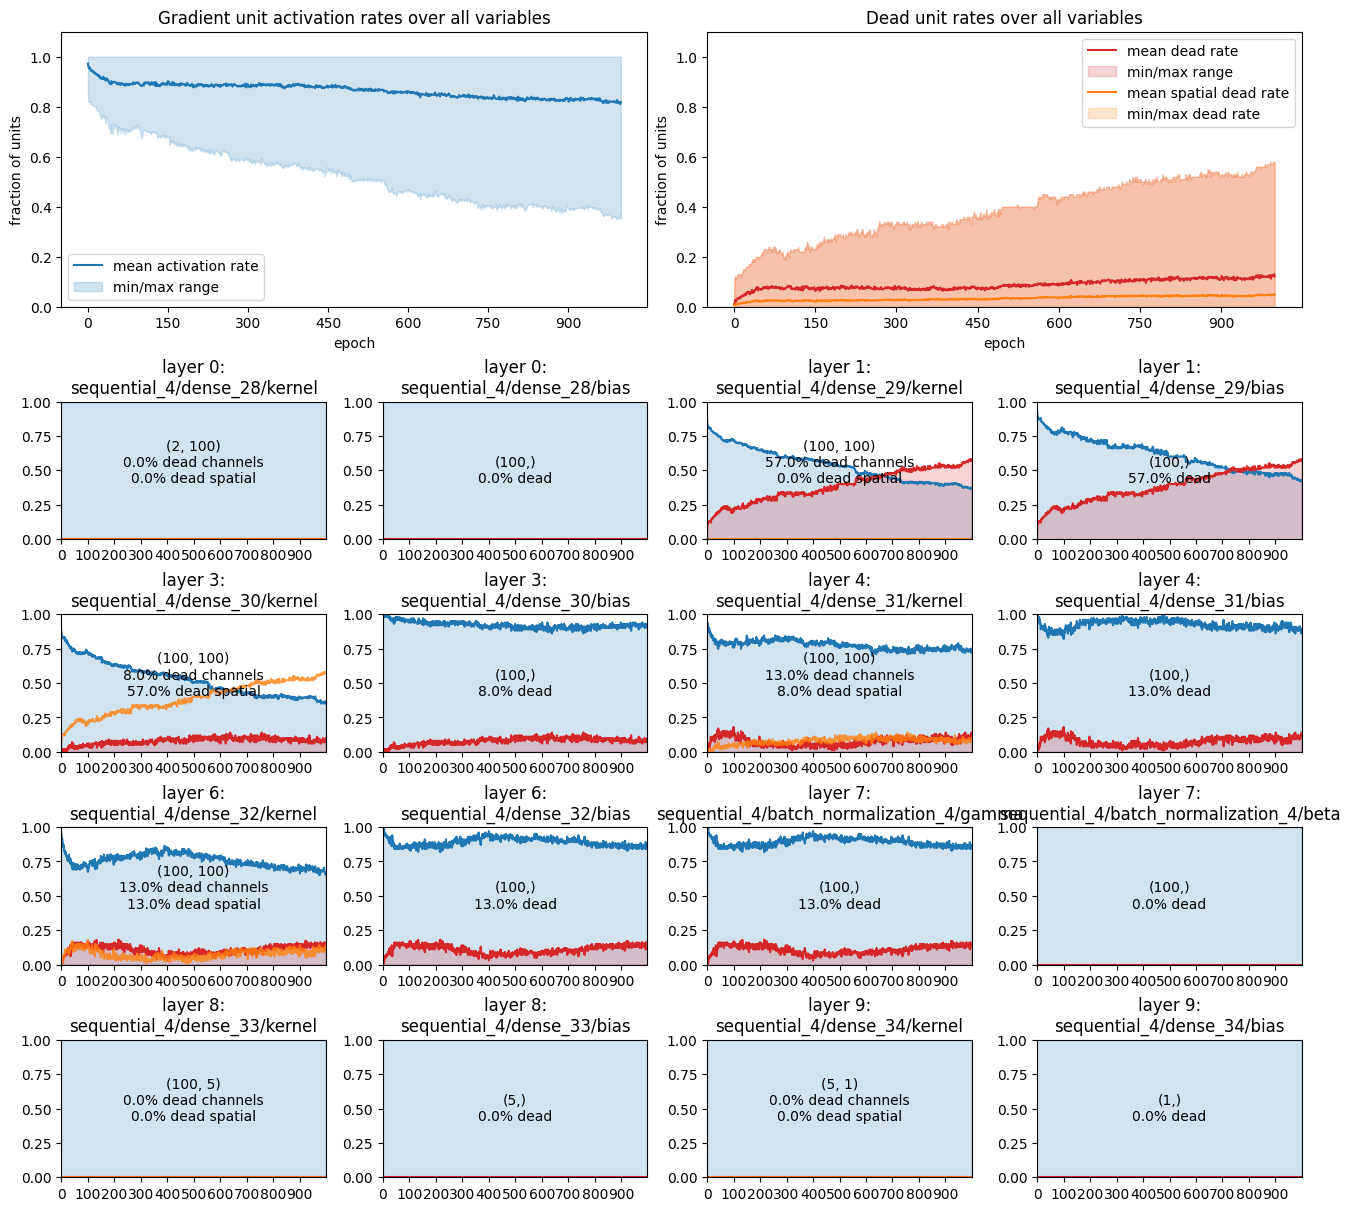

In [5]:
tinstr.plot_activity_history(gradients)

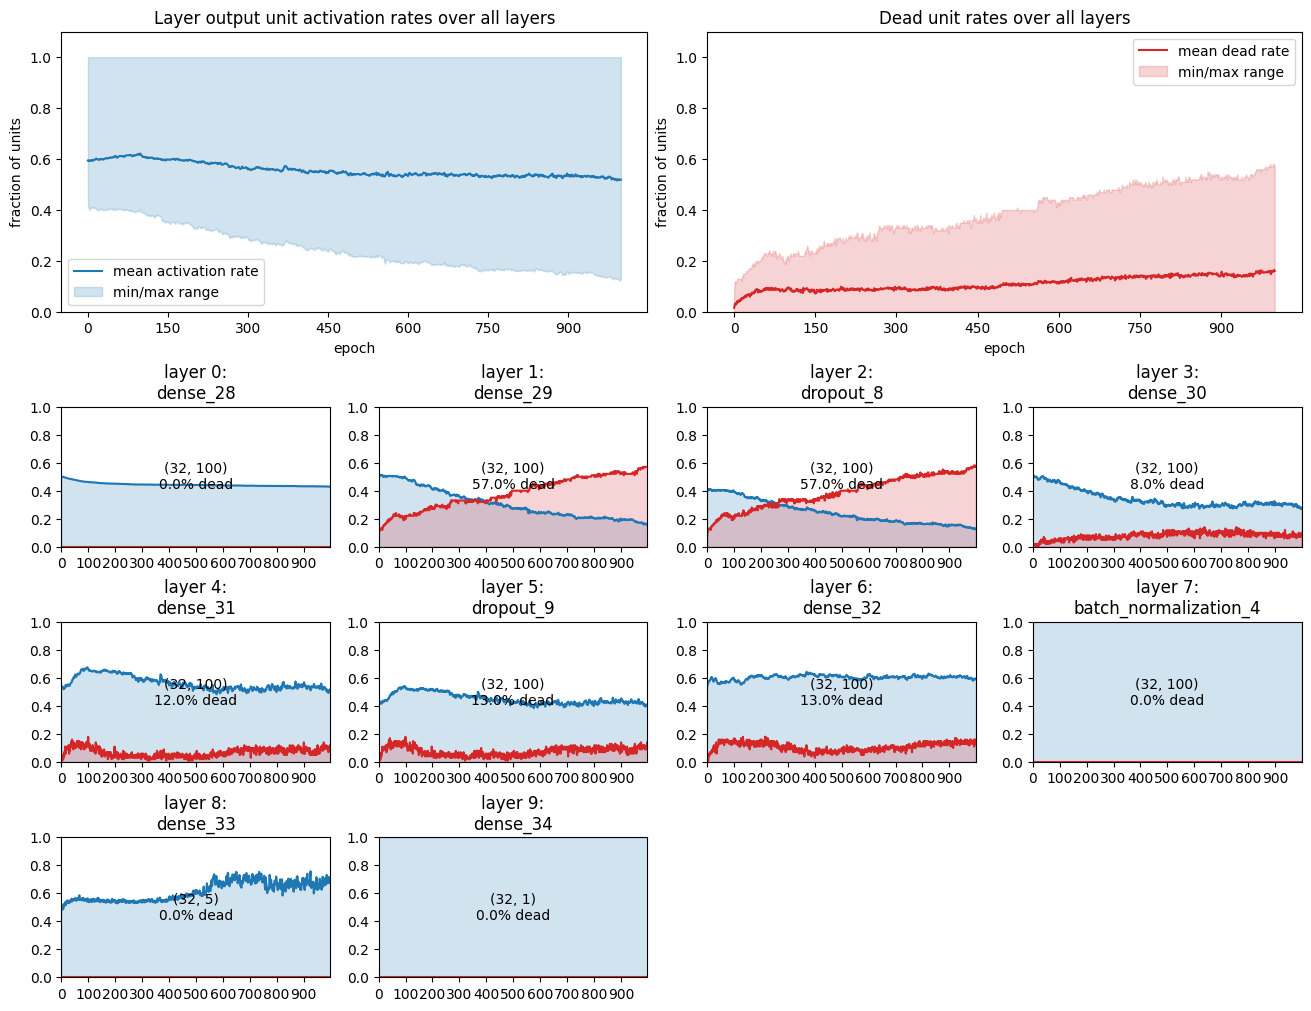

In [6]:
# temp
tinstr.plot_activity_history(outputs)

## Basic Near-Zero Gradients Report

Depending on the training run, the `kernel` (weights) of the second layer get to somewhere between 40% to 60% neuron death by the end. There's a slow but steady increase from near 0% at the start. So there's no obvious point where it _suddenly_ looses neurons (which can happen). In this case starting at the last epoch is as good as any.

Let's generate a train-explainer report...

In [7]:
epoch = variables.epochs[-1]  # select last epoch
texpl.explain_near_zero_gradients([variables, gradients, outputs, output_gradients], target_layer_idx, epoch=epoch)

Examining layer #1 at iteration 999:
  layer:               dense_29
  units:               100
  weights:             10000
  input from layers:   [0]
  output to layers:    [2]
  near-zero gradients: 6266 (62.7%) = 0

Let:
  A_0      <- input activation to target layer
  W_l      <- weights of target layer
  Z_l      <- pre-activation output of target layer
  S_l      <- effect of activation function as element-wise multiplier
  A_l      <- output activation of target layer

Forward pass...
A_0 - input value:
  shape:             (12, 100) -> total values: 1200
  summary:           57.2% near-zero
W_l - weights of target layer:
  shape:             (100, 100) -> total values: 10000
  summary:           1.0% near-zero
  corresponding to near-zero gradients: 1.1% near-zero
compute Z_l = A_0 . W_l + b_l:
  inputs examined:   A_0, W_l
  summary:           1.0% near-zero
Z_l - pre-activation output:
  shape:             (12, 100) -> total values: 1200
  summary:           84.9% negative, 

So what can we infer from this?

First, let's pull out the major points of interest. Note that the snippet here may have slightly different numbers from what you've just obtained above:

> ```
> A_0 - input value:
>   summary:           55.9% near-zero
> Z_l - pre-activation output:
>   summary:           86.5% negative, 70.0% of units always near-zero or negative across all batch dims
> compute dJ/dZ_l = dJdA_l (.) S_l:
>   summary:           89.5% near-zero, of which 96.6% are affected by near-zero values from S_l
> ```

The core problem is that `Z_l` (the pre-activation layer values) is producing negative values. This is leading to `S_l` (the post-activation layer outputs) being mostly zero. This has flow-on effects during backprop, where the zeros in `S_l` leads to zeroing out of most of the inbound gradients (dJ/dZ) before variable gradients are computed.

It's interesting to note that weight gradients (dJ/dW) are not as badly affected as the first part of the inbound gradients (dJ/dZ). This gives a clue as to how it's possible for networks to sometimes recover from dead units.

A quick clarification before we continue: I've misused `A_0` to refer to the input to the target layer, regardless of whether it's the first layer's input or any other. That's because I can't think of a cleaner way to represent $A_{l-1}$ in code. I'll continue to use `A_0` with this somewhat corrupted meaning throughout much of this notebook.


## Verbose Report

The `explain_near_zero_gradients()` function has a verbose mode where it gives more of its internal calculations and presents more detailed statistics:


In [8]:
epoch = variables.epochs[-1]  # select last epoch
texpl.explain_near_zero_gradients([variables, gradients, outputs, output_gradients], target_layer_idx, epoch=epoch, verbose=True)

Examining layer #1 at iteration 999:
  layer:               dense_29
  units:               100
  weights:             10000
  input from layers:   [0]
  output to layers:    [2]
  near-zero gradients: 6266 (62.7%) = 0

Let:
  A_0      <- input activation to target layer
  W_l      <- weights of target layer
  Z_l      <- pre-activation output of target layer
  S_l      <- effect of activation function as element-wise multiplier
  A_l      <- output activation of target layer
  PZN      <- breakdown of values into (P)ositive, near-(Z)ero, or (N)egative
  x . y    <- matmul (aka dot product)
  x (.) y  <- element-wise multiply

Forward pass...
A_0 - input value:
  shape:             (12, 100) -> total values: 1200
  summary:           57.2% near-zero (= 0), 0.0% of units always near-zero across all batch dims
  value percentiles: [0, 25, 50, 75, 100] -> [0.         0.         0.         0.46250117 1.8669223 ]
  PZN counts/sums:   Z: 687.0 = Σ 0.0, P: 513.0 = Σ 319.4
  PZN counts/means: 

**Explaining verbose output**

There's a lot in there, which is why I start with the non-verbose version.

Before we try to draw any conclusions, let's pull out a few things and explain what's going on.

First up, `A_0`, the input to the target layer:

> ```
> A_0 - input value:
>   shape:             (12, 100) -> total values: 1200
>   summary:           55.9% near-zero (= 0), 0.0% of units always near-zero across all batch dims
>   value percentiles: [0, 25, 50, 75, 100] -> [0.         0.         0.         0.47027892 1.9822227 ]
>   PZN counts/sums:   Z: 671.0 = Σ 0.0, P: 529.0 = Σ 336.7
>   PZN counts/means:  Z: 55.9% x 0.000000, P: 44.1% x 0.636509
> ```

55.9% near-zero. But that's not the whole picture. That's only on average. Across all samples available, all units are active at some point - there's no dead units.

"PZN" refers to the positive, near-zero, and negative classifications that I mentioned earlier. The above shows how `A_0` is made up of 44.1% positive values (529 in absolute numbers) that together sum to 336.7. Alternatively, you could view that as 529 values with a mean of 0.637. It also shows that it is made up of 55.9% zero or near-zero values. More formally, the two PZN rows list stats for each PZN class in each of two styles:
* `{count}={sum}` (eg: `529.0 = Σ 336.7`) - the total number of elements in the class, along with the sum of those values
* `{percent}={mean}` (eg: `44.1% x 0.636509`) - the percentage of elements in the tensor that fall into the class, along with their mean value

The definition of "near-zero" is dynamically calculated for each tensor. By default it's computed with a threshold at the 1st-percentile. This means that healthy tensors with a nice range of values will always have exactly 1.0% near-zero values. For "non-healthy" tensors, it might pick the threshold at exactly zero. The bit in brackets here tells us that it's chosen exactly-zero as the threshold for `A_0`: `55.9% near-zero (= 0)`.

Now, jump down to the calculation of `dJ/dZ_l` (the first part of backprop calculation within the layer):
> ```
> compute dJ/dZ_l = dJdA_l (.) S_l:
>   inputs examined:   dJ/dA_l, S_l
>   summary:           89.5% near-zero, of which 96.6% are affected by near-zero values from S_l
>   PZN combinations:  NZ: 455.0 = Σ 0.00000000, PZ: 384.0 = Σ 0.00000000, ZZ: 199.0 = Σ 0.00000000, NP: 84.0 = Σ -0.00127121, PP: 42.0 = Σ 0.00117339, ZP: 36.0 = Σ 0.00000000
>   PZN combinations:  NZ: 37.9% x 0.0000000000, PZ: 32.0% x 0.0000000000, ZZ: 16.6% x 0.0000000000, NP: 7.0% x -0.0000151335, PP: 3.5% x 0.0000279379, ZP: 3.0% x 0.0000000000
> ```

The summary says it all: the problem is that `S_l` has many zero or near-zero values. But we can see that for ourselves if we look closer. This block of the report and others like it extend the PZN concept through the matrix operations. Here we have variables `dJdA_l` and `S_l` that are each separately analysed in terms of their numbers of positive, near-zero, and negative values, and then the combinations of those three classes are analysed in the result. Thus we have 455 element-wise multiplications resulting from `dJdA_l` being negative and `S_l` being zero or near-zero. Looking across we see that we have NZ + PZ + ZZ combinations spanning a sum of 86.5% of the total elements in the resultant matrix. In other words, it doesn't matter much what the values of `dJdA_l` are, because most are getting multiplied against zeros from `S_l`.

The next block in the report breaks that out further by i) reporting on the same stats but just for those element that are near-zero, and ii) doing automatic analysis of the PZN combinations:
> ```
> dJ/dZ_l 89.5% near zero (= 0):
>   PZN combinations:  NZ: 455.0 = Σ 0.000, PZ: 384.0 = Σ 0.000, ZZ: 199.0 = Σ 0.000, ZP: 36.0 = Σ 0.000
>   PZN combinations:  NZ: 42.4% x 0.000, PZ: 35.8% x 0.000, ZZ: 18.5% x 0.000, ZP: 3.4% x 0.000
>   96.6% affected by near-zero values from S_l
>   100.0% affected by near-zero values from either input
>   21.9% affected by near-zero values from dJ/dA_l
> ```

The automatic analysis isn't perfect. It repeats itself a little. But it's got the the crux point quite nicely (96.6% of the resultant near-zero values are caused by `S_l`) and perhaps shown us something we wouldn't have so easily identified ourselves (21.9% of near-zero values are contributed to by `dJ/dA_l` being near-zero).




**Conclusion revisions from verbose report**

Our overal conclusion hasn't changed. But some things have become a little more refined. The non-verbose report applies some heuristics to drill down to what it believes to be the most _pertinent_ information, but it sometimes gets that wrong.

> ```
> A_0 - input value:
>   brief:           55.9% near-zero
>   verbose:         55.9% near-zero (= 0), 0.0% of units always near-zero across all batch dims
> ```

We first thought that 55.9% of `A_0` was near-zero. It turns out that such a statement is only true on average. There are in fact no dead units. `A_0` is likely not the cause of our problems.

> ```
> W_l - weights of target layer:
>   shape:             (100, 100) -> total values: 10000
>   summary:           1.0% near-zero (< 0.0019927648827433586)
>   value percentiles: [0, 25, 50, 75, 100] -> [-1.1143992e+00 -1.0876491e-01  8.4966136e-04  1.1162956e-01  4.7653157e-01]
> ```

I didn't bring this up before, but I'll briefly mention the weights tensor. In my experience, it's pretty typical that the weights are not directly the cause of dead units - ie: dead units are usually _not_ caused by the weights tending towards zero. The above is pretty typical, with weights falling roughly equally on either side of zero.

> ```
> Z_l - pre-activation output:
>   brief:             86.5% negative, 70.0% of units always near-zero or negative across all batch dims
>   verbose:           86.5% negative, 1.0% near-zero (< 0.017070427536964417), 70.0% of units always near-zero or negative across all batch dims
> ```

Further corroborating the commentary about the weights, our problems with `Z_l` are specifically on its negative values. The number of near-zero values is exactly according to definition.

> ```
> compute dJ/dW_l = A_0^T . dJ/dZ_l:
>    brief:           66.1% near-zero, of which 99.0% are affected by near-zero values from dJ/dZ_l
> dJ/dW_l 66.1% near zero (= 0):
>    verbose:         99.0% affected by near-zero values from dJ/dZ_l
>    verbose:         56.4% affected by near-zero values from A_0^T
> ```

While there are no dead units from `A_0`, and while the negative `Z_l` is our biggest concern, the high percentage of zero values from `A_0` is also having a noticeable impact.


## TEMP


In [9]:
epochN = variables.epochs[-1]
epoch = 1
inp = outputs.layer_outputs[0][epoch]
w = variables.variables[2][epoch]
g = gradients.gradients[2][epoch]
gN = gradients.gradients[2][epochN]
outp = outputs.layer_outputs[1][epoch]
outpN = outputs.layer_outputs[1][epochN]
print(f"epoch:     {epoch}")
print(f"input:     {inp.shape}")
print(f"weights:   {w.shape}")
print(f"gradients: {g.shape}")
print(f"outputs:   {outp.shape}")

epoch:     1
input:     (12, 100)
weights:   (100, 100)
gradients: (100, 100)
outputs:   (12, 100)


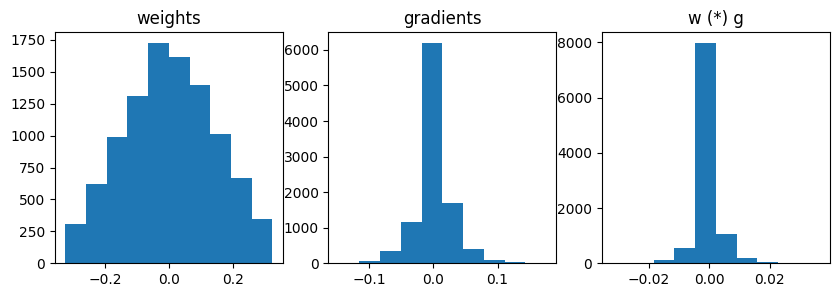

In [10]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title("weights")
plt.hist(np.reshape(w, (-1)))

plt.subplot(1,3,2)
plt.title("gradients")
plt.hist(np.reshape(g, (-1)))

plt.subplot(1,3,3)
plt.title("w (*) g")
plt.hist(np.reshape(w * g, (-1)))

plt.show()

In [11]:
def dead_mask(t, axis=0):
  # default: assumes there's a batch dimension to reduce over
  return np.sum(np.abs(t), axis=axis) == 0.0

print(f"any    0.0 gradients - g{epoch}: {np.sum(g == 0.0) / np.size(g) * 100:.1f}%")
print(f"any    0.0 gradients - gN: {np.sum(gN == 0.0) / np.size(gN) * 100:.1f}%")
print(f"any    0.0 outputs   - outp{epoch}: {np.sum(outp == 0.0) / np.size(outp) * 100:.1f}%")
print(f"any    0.0 outputs   - outpN: {np.sum(outpN == 0.0) / np.size(outpN) * 100:.1f}%")
print(f"always 0.0 outputs   - outp{epoch}: {np.sum(dead_mask(outp)) / np.size(dead_mask(outp)) * 100:.1f}%")
print(f"always 0.0 outputs   - outpN: {np.sum(dead_mask(outpN)) / np.size(dead_mask(outpN)) * 100:.1f}%")

any    0.0 gradients - g1: 18.1%
any    0.0 gradients - gN: 62.7%
any    0.0 outputs   - outp1: 48.5%
any    0.0 outputs   - outpN: 84.4%
always 0.0 outputs   - outp1: 12.0%
always 0.0 outputs   - outpN: 68.0%


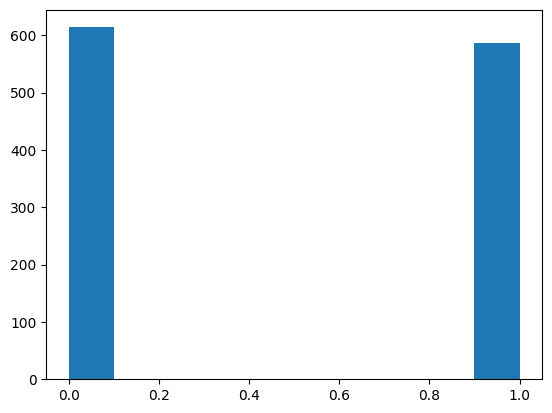

In [12]:
plt.hist(np.reshape(np.sign(inp), (-1)))
plt.show()

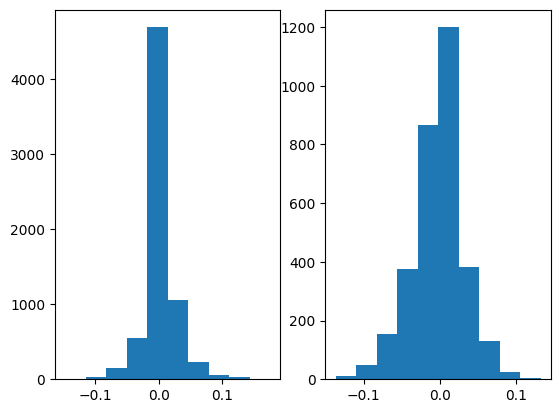

In [13]:
m = dead_mask(outpN)
masked = g.numpy()[:,m]
opp_masked = g.numpy()[:,np.invert(m)]

plt.subplot(1,2,1)
plt.hist(np.reshape(masked, (-1)))
plt.subplot(1,2,2)
plt.hist(np.reshape(opp_masked, (-1)))
plt.show()

mask: dead=0, rest=100


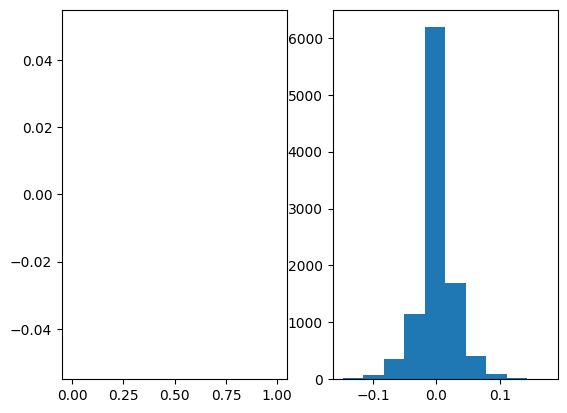

In [14]:
m = dead_mask(inp, axis=0)
print(f"mask: dead={np.sum(m)}, rest={np.sum(np.invert(m))}")
masked = g.numpy()[m,:]
opp_masked = g.numpy()[np.invert(m),:]

plt.subplot(1,2,1)
plt.hist(np.reshape(masked, (-1)))
plt.subplot(1,2,2)
plt.hist(np.reshape(opp_masked, (-1)))
plt.show()

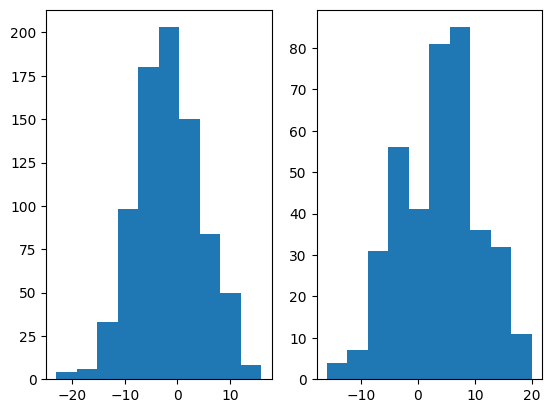

In [15]:
m = dead_mask(outpN)
masked = np.matmul(np.sign(inp), np.sign(w))[:,m]
opp_masked = np.matmul(np.sign(inp), np.sign(w))[:,np.invert(m)]

plt.subplot(1,2,1)
plt.hist(np.reshape(masked, (-1)))
plt.subplot(1,2,2)
plt.hist(np.reshape(opp_masked, (-1)))
plt.show()

masked:
  - negative: 374  = 45.8%
  - positive: 289
opposite masked:
  - negative: 184  = 47.9%
  - positive: 196


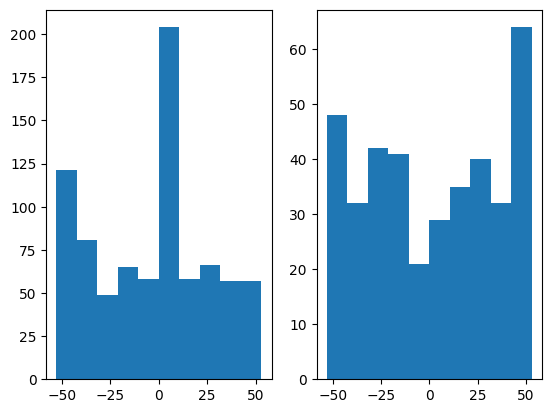

In [16]:
m = dead_mask(outpN)
masked = np.matmul(np.sign(inp), np.sign(-g))[:,m]
opp_masked = np.matmul(np.sign(inp), np.sign(-g))[:,np.invert(m)]

print(f"masked:")
print(f"  - negative: {np.sum(masked < 0)}  = {np.sum(masked < 0) / np.size(masked) * 100:.1f}%")
print(f"  - positive: {np.sum(masked > 0)}")
print(f"opposite masked:")
print(f"  - negative: {np.sum(opp_masked < 0)}  = {np.sum(opp_masked < 0) / np.size(opp_masked) * 100:.1f}%")
print(f"  - positive: {np.sum(opp_masked > 0)}")

plt.subplot(1,2,1)
plt.hist(np.reshape(masked, (-1)))
plt.subplot(1,2,2)
plt.hist(np.reshape(opp_masked, (-1)))
plt.show()

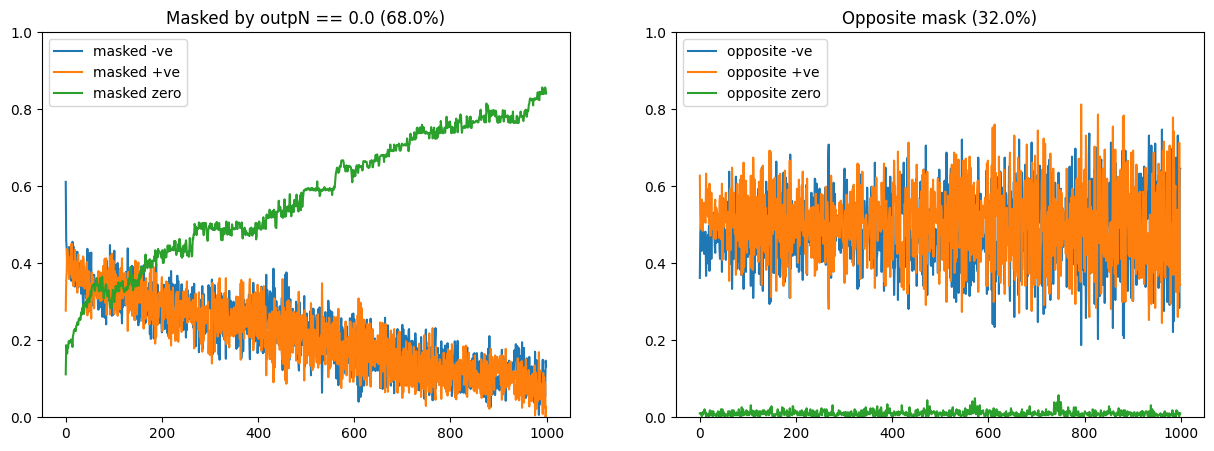

In [17]:
m_n = []
m_p = []
m_z = []
o_n = []
o_p = []
o_z = []
m = dead_mask(outpN)
for e in outputs.epochs:
  inp_e = outputs.layer_outputs[0][e]
  g = gradients.gradients[2][e]

  masked = np.matmul(np.sign(inp), np.sign(-g))[:,m]
  opp_masked = np.matmul(np.sign(inp), np.sign(-g))[:,np.invert(m)]

  m_n.append(np.sum(masked < 0) / np.size(masked))
  m_p.append(np.sum(masked > 0) / np.size(masked))
  m_z.append(np.sum(masked == 0) / np.size(masked))
  o_n.append(np.sum(opp_masked < 0) / np.size(opp_masked))
  o_p.append(np.sum(opp_masked > 0) / np.size(opp_masked))
  o_z.append(np.sum(opp_masked == 0) / np.size(opp_masked))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title(f"Masked by outpN == 0.0 ({np.sum(m) / np.size(m) * 100:.1f}%)")
plt.plot(m_n, label="masked -ve")
plt.plot(m_p, label="masked +ve")
plt.plot(m_z, label="masked zero")
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title(f"Opposite mask ({np.sum(np.invert(m)) / np.size(m) * 100:.1f}%)")
plt.plot(o_n, label="opposite -ve")
plt.plot(o_p, label="opposite +ve")
plt.plot(o_z, label="opposite zero")
plt.ylim(0.0,1.0)
plt.legend()

plt.show()

Discussion:
* `(inp * -g)` results increasingly made up of zeros in masked results because the gradients themselves increasingly have zeros in those same spots -- a net result of the outputs increasingly having zeros.
* Thus this the masked plot doesn't _explain_ why we're getting zeros in the outputs, it's only showing the _effect_ of zeros in the outputs.
* It's quite amazing that the opposite masked plot shows a flat-line trend. This means that there's a ~100% correlation between the elements in the outputs that are trending towards zero and the gradients.

In [18]:
# re-usable code
A = tf.random.uniform((12, 100))
W = tf.random.uniform((100, 80))

def corr(X, Y):
  """
  Simple element-wise correlation between two tensors.
  Return:
    scalar Pearson correlation coefficient
  """
  return np.corrcoef(np.reshape(X, (-1)), np.reshape(Y, (-1)))[0, 1]

def matmul_corr(X, Y):
  """
  Calculates the respective correlations between each row of X and each column of Y.
  Returns:
    tensor with same shape as would be returned by np.matmul(X, Y)
  """
  def tile_Y_col_for_X(Y_col, X):
    return tf.tile(tf.expand_dims(Y_col, 0), (X.shape[0], 1))
  def corr_X_to_Y_col(X, Y_col):
    return tfp.stats.correlation(X[:, :], tile_Y_col_for_X(Y_col, X), sample_axis=1, event_axis=None)
  corr_matrix = tf.map_fn(lambda w_col: corr_X_to_Y_col(X, w_col), tf.transpose(Y))
  return np.transpose(corr_matrix)  # back to correct orientation, and also convert to numpy

#tfp.stats.correlation(A[0, :], tf.transpose(W)[0], sample_axis=0, event_axis=None)
#tf.tile(tf.expand_dims(tf.transpose(W)[0], 0), (A.shape[0], 1)).shape
#tfp.stats.correlation(A[:, :], tile_W_col_for_A(tf.transpose(W)[0], A), sample_axis=1, event_axis=None)
#tf.map_fn(lambda w_col: corr_A_to_W_col(A, w_col), tf.transpose(W)).shape
#tfp.stats.correlation(A, W, sample_axis=0).shape

C = matmul_corr(A, W)
print(f"C: {C.shape}, range: {np.min(C)} .. {np.max(C)}")

C: (12, 80), range: -0.30459100008010864 .. 0.3175642788410187


xcorr(d_inp, w):


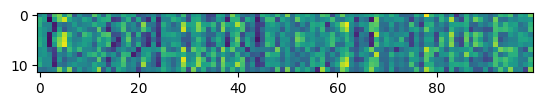

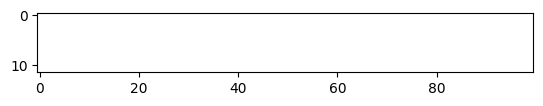

xcorr(inp, w):
  - sign(inp) vs sign(w) - all:    -0.0016521867364645004
  - sign(inp) vs sign(w) - masked: -0.001082689268514514
  - sign(inp) vs w       - all:    -0.001953097409568727
  - sign(inp) vs w       - masked: -0.00017609918722882867
  - sign(inp) vs w       - opp.:   -0.005729218479245901


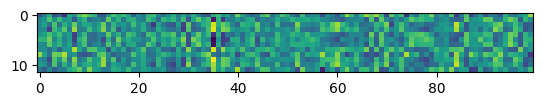

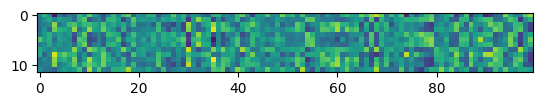

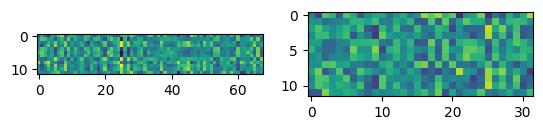

xcorr(inp, -g):


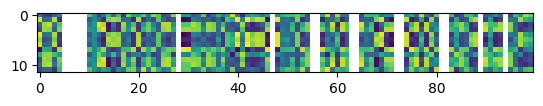

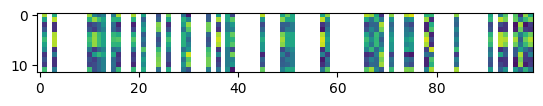

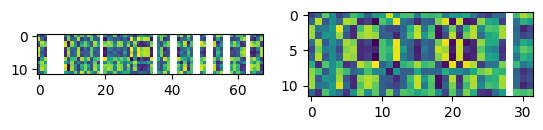

In [19]:
# let's try some correlation calculations
epochN = variables.epochs[-1]
epoch = 1
inp = outputs.layer_outputs[0][epoch]
d_inp = inp - outputs.layer_outputs[0][epoch-1]
d_s_inp = np.sign(inp) - np.sign(outputs.layer_outputs[0][epoch-1])
w = variables.variables[2][epoch]
g = gradients.gradients[2][epoch]
gN = gradients.gradients[2][epochN]
outp = outputs.layer_outputs[1][epoch]
outpN = outputs.layer_outputs[1][epochN]
m = dead_mask(outpN)

print(f"xcorr(d_inp, w):")
plt.imshow(matmul_corr(np.sign(d_inp), w))
plt.show()
plt.imshow(matmul_corr(d_s_inp, np.sign(w)))
plt.show()


print("xcorr(inp, w):")
print(f"  - sign(inp) vs sign(w) - all:    {np.mean(matmul_corr(np.sign(inp), np.sign(w)))}")
print(f"  - sign(inp) vs sign(w) - masked: {np.mean(matmul_corr(np.sign(inp), np.sign(w))[:,m])}")
print(f"  - sign(inp) vs w       - all:    {np.mean(matmul_corr(np.sign(inp), w))}")
print(f"  - sign(inp) vs w       - masked: {np.mean(matmul_corr(np.sign(inp), w)[:,m])}")
print(f"  - sign(inp) vs w       - opp.:   {np.mean(matmul_corr(np.sign(inp), w)[:,np.invert(m)])}")
vmin = np.nanmin(matmul_corr(np.sign(inp), np.sign(w)))
vmax = np.nanmax(matmul_corr(np.sign(inp), np.sign(w)))
plt.imshow(matmul_corr(np.sign(inp), np.sign(w)), vmin=vmin, vmax=vmax)
plt.show()

plt.imshow(matmul_corr(np.sign(inp), w), vmin=vmin, vmax=vmax)
plt.show()

plt.subplot(1,2,1)
plt.imshow(matmul_corr(np.sign(inp), np.sign(w))[:,m], vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(matmul_corr(np.sign(inp), np.sign(w))[:,np.invert(m)], vmin=vmin, vmax=vmax)
plt.show()

print("xcorr(inp, -g):")
vmin = np.nanmin(matmul_corr(np.sign(inp), np.sign(-g)))
vmax = np.nanmax(matmul_corr(np.sign(inp), np.sign(-g)))
plt.imshow(matmul_corr(np.sign(inp), np.sign(-g)), vmin=vmin, vmax=vmax)
plt.show()

plt.imshow(matmul_corr(np.sign(inp), np.sign(-gN)), vmin=vmin, vmax=vmax)
plt.show()

plt.subplot(1,2,1)
plt.imshow(matmul_corr(np.sign(inp), np.sign(-g))[:,m], vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(matmul_corr(np.sign(inp), np.sign(-g))[:,np.invert(m)], vmin=vmin, vmax=vmax)
plt.show()

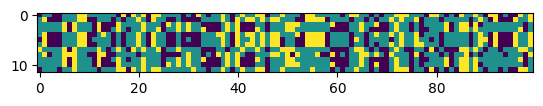

In [20]:
plt.imshow(np.sign(d_inp))

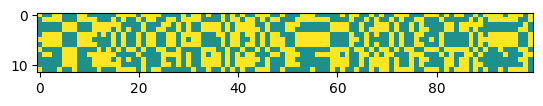

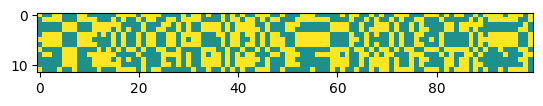

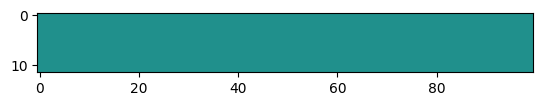

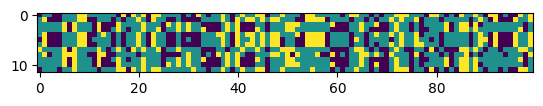

In [21]:
inp = outputs.layer_outputs[0][epoch]
d_inp = inp - outputs.layer_outputs[0][epoch-1]
d_s_inp = np.sign(inp) - np.sign(outputs.layer_outputs[0][epoch-1])

plt.imshow(np.sign(inp), vmin=-1, vmax=1)
plt.show()
plt.imshow(np.sign(outputs.layer_outputs[0][epoch-1]), vmin=-1, vmax=1)
plt.show()
plt.imshow(d_s_inp, vmin=-2, vmax=2)
plt.show()
plt.imshow(np.sign(d_inp), vmin=-1, vmax=1)
plt.show()

In [22]:
epochN = variables.epochs[-1]
epoch = 1
inp = outputs.layer_outputs[0][epoch]
d_inp = inp - outputs.layer_outputs[0][epoch-1]
w = variables.variables[2][epoch]
b = variables.variables[3][epoch]
d_b = b - variables.variables[3][epoch-1]
g = gradients.gradients[2][epoch]
gN = gradients.gradients[2][epochN]
outp = outputs.layer_outputs[1][epoch]
outpN = outputs.layer_outputs[1][epochN]

m = dead_mask(outpN)
masked = np.matmul(np.sign(inp), np.sign(-g))[:,m]
opp_masked = np.matmul(np.sign(inp), np.sign(-g))[:,np.invert(m)]

corr(d_b, m)

-0.2845948127760963

full:   (12, 100) - range -2.8030755519866943 .. 3.211325168609619, nans: 0, mean: 0.060644861310720444
masked: (12, 68) - range -2.8030755519866943 .. 2.1301772594451904, nans: 0, mean: -0.21112655103206635
opp.:   (12, 32) - range -1.7238926887512207 .. 3.211325168609619, nans: 0, mean: 0.6381590962409973


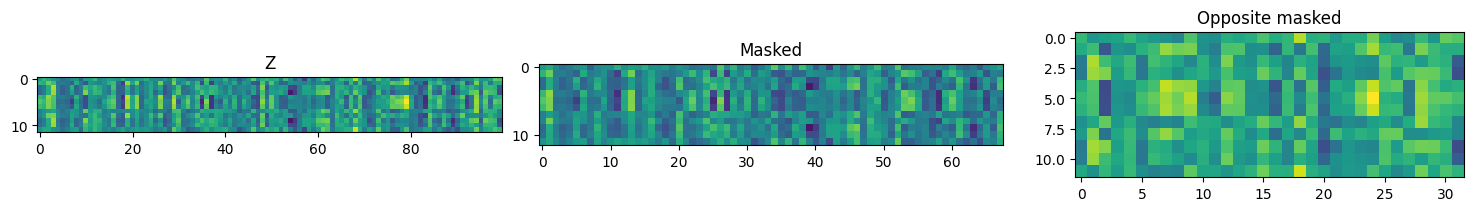

full:   (12, 100) - range -1.0 .. 1.0, nans: 0, mean: 0.0016666667070239782
masked: (12, 68) - range -1.0 .. 1.0, nans: 0, mean: -0.23284313082695007
opp.:   (12, 32) - range -1.0 .. 1.0, nans: 0, mean: 0.5


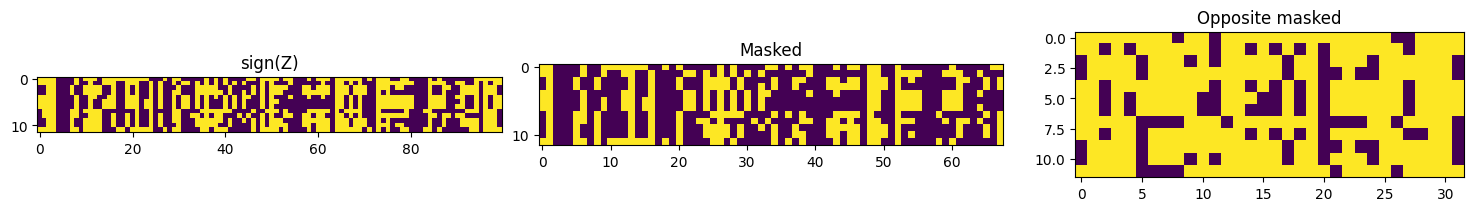

full:   (1, 100) - range -12.0 .. 12.0, nans: 0, mean: 0.019999999552965164
masked: (1, 68) - range -12.0 .. 12.0, nans: 0, mean: -2.7941176891326904
opp.:   (1, 32) - range -8.0 .. 12.0, nans: 0, mean: 6.0


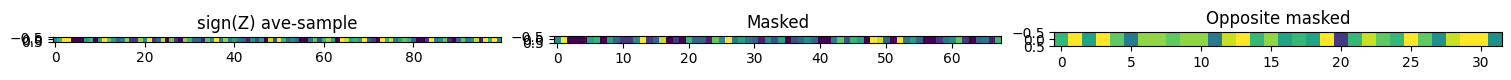

full:   (12, 100) - range -0.1719886064529419 .. 0.21907484531402588, nans: 0, mean: 0.0027863597497344017
masked: (12, 68) - range -0.1719886064529419 .. 0.21907484531402588, nans: 0, mean: 0.0008367084083147347
opp.:   (12, 32) - range -0.16598987579345703 .. 0.18893170356750488, nans: 0, mean: 0.006929369643330574


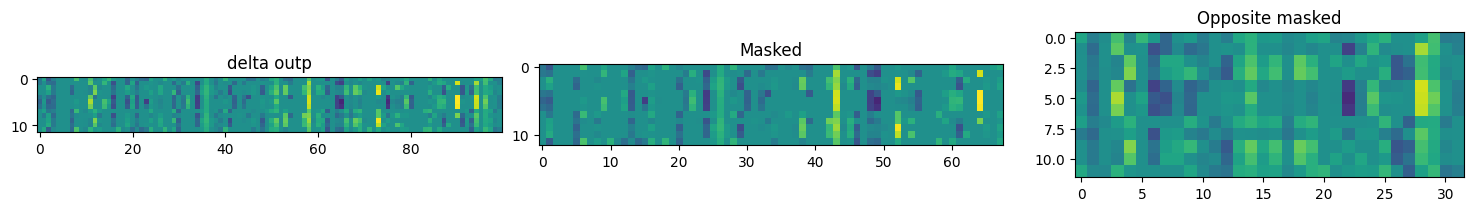

full:   (12, 100) - range -1.0 .. 1.0, nans: 0, mean: 0.030833333730697632
masked: (12, 68) - range -1.0 .. 1.0, nans: 0, mean: 0.018382353708148003
opp.:   (12, 32) - range -1.0 .. 1.0, nans: 0, mean: 0.0572916679084301


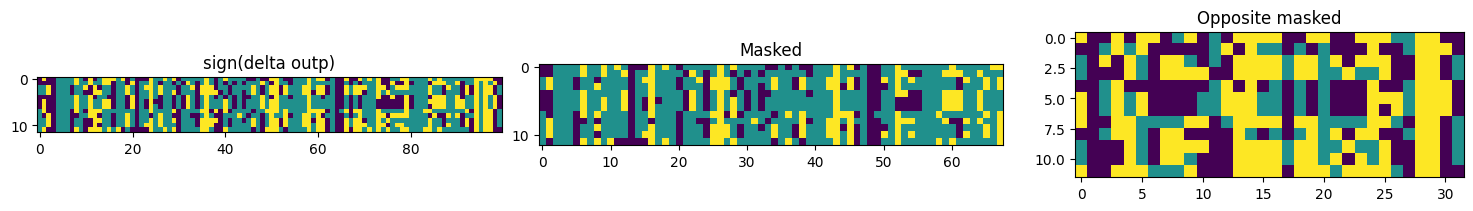

full:   (12, 100) - range -1.0 .. 1.0, nans: 0, mean: -0.0008333333535119891
masked: (12, 68) - range -1.0 .. 1.0, nans: 0, mean: -0.006127451080828905
opp.:   (12, 32) - range -1.0 .. 1.0, nans: 0, mean: 0.010416666977107525


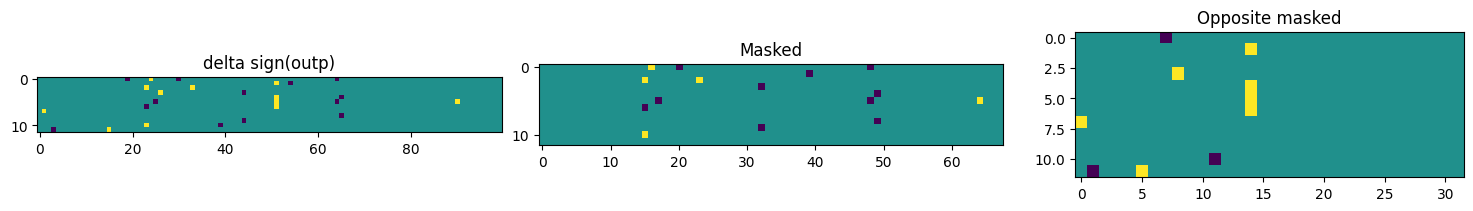

In [27]:
# starting at the top-level first and following the splits from there
# - so that we start with a clear separation between masked and non-masked
inp = outputs.layer_outputs[0][epoch]
d_inp = inp - outputs.layer_outputs[0][epoch-1]
w = variables.variables[2][epoch]
b = variables.variables[3][epoch]
g = gradients.gradients[2][epoch]
gN = gradients.gradients[2][epochN]
outp = outputs.layer_outputs[1][epoch]
d_outp = outputs.layer_outputs[1][epoch+1] - outp
d_s_outp = np.sign(outputs.layer_outputs[1][epoch+1]) - np.sign(outp)
outpN = outputs.layer_outputs[1][epochN]

m = dead_mask(outpN)
Z = np.array(np.matmul(inp, w) + b)
masked = Z[:,m]
opp_masked = Z[:,np.invert(m)]

def balanced_min_max(X):
  fmin = np.nanmin(X)
  fmax = np.nanmax(X)
  mmax = max(np.abs(fmin), np.abs(fmax))
  return (-mmax, +mmax)

def plot_imshow_triple_masked(X, mask, title=None, colorbar=False):
  def print_summary(A):
    return f"{A.shape} - range {np.nanmin(A)} .. {np.nanmax(A)}, nans: {np.sum(np.isnan(A))}, mean: {np.mean(A)}"
  X = np.array(X)
  vmin, vmax = balanced_min_max(X)
  print(f"full:   " + print_summary(X))
  print(f"masked: " + print_summary(X[:,mask]))
  print(f"opp.:   " + print_summary(X[:,np.invert(mask)]))
  plt.figure(figsize=(15,2), layout='constrained')
  plt.subplot(1,3,1)
  plt.title(title or "Full")
  plt.imshow(X, vmin=vmin, vmax=vmax)

  plt.subplot(1,3,2)
  plt.title("Masked")
  plt.imshow(X[:,mask], vmin=vmin, vmax=vmax)

  plt.subplot(1,3,3)
  plt.title("Opposite masked")
  plt.imshow(X[:,np.invert(mask)], vmin=vmin, vmax=vmax)
  if colorbar:
    plt.colorbar()

  plt.show()

plot_imshow_triple_masked(Z, m, title="Z")
plot_imshow_triple_masked(np.sign(Z), m, title="sign(Z)")
plot_imshow_triple_masked(np.sum(np.sign(Z), axis=0, keepdims=True), m, title="sign(Z) ave-sample")

plot_imshow_triple_masked(d_outp, m, title="delta outp")
plot_imshow_triple_masked(np.sign(d_outp), m, title="sign(delta outp)")
plot_imshow_triple_masked(d_s_outp, m, title="delta sign(outp)")



full:   (12, 100) - range -1.0 .. 1.0, nans: 0, mean: -0.021666666492819786
masked: (12, 68) - range -1.0 .. 1.0, nans: 0, mean: -0.12377450615167618
opp.:   (12, 32) - range -1.0 .. 1.0, nans: 0, mean: 0.1953125


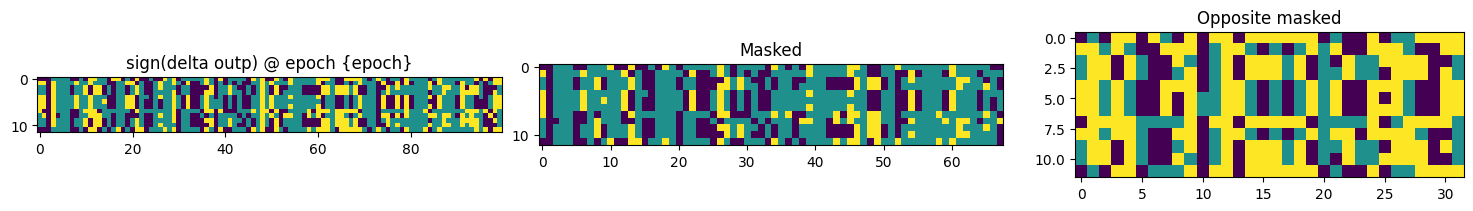

full:   (12, 100) - range -1.0 .. 1.0, nans: 0, mean: -0.04416666552424431
masked: (12, 68) - range -1.0 .. 1.0, nans: 0, mean: -0.07352941483259201
opp.:   (12, 32) - range -1.0 .. 1.0, nans: 0, mean: 0.01822916604578495


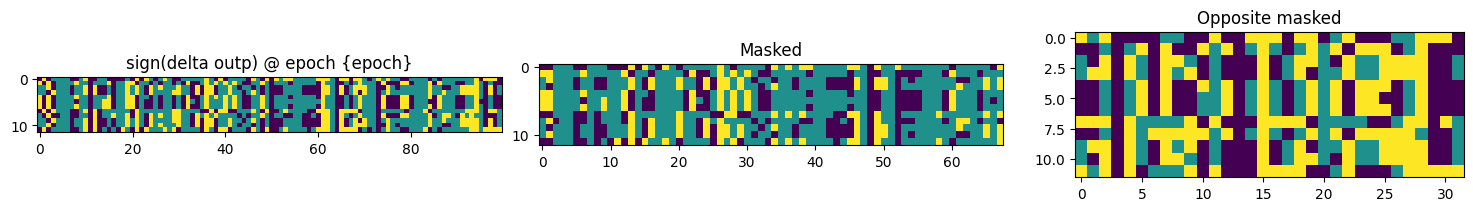

full:   (12, 100) - range -1.0 .. 1.0, nans: 0, mean: 0.017500000074505806
masked: (12, 68) - range -1.0 .. 1.0, nans: 0, mean: -0.022058824077248573
opp.:   (12, 32) - range -1.0 .. 1.0, nans: 0, mean: 0.1015625


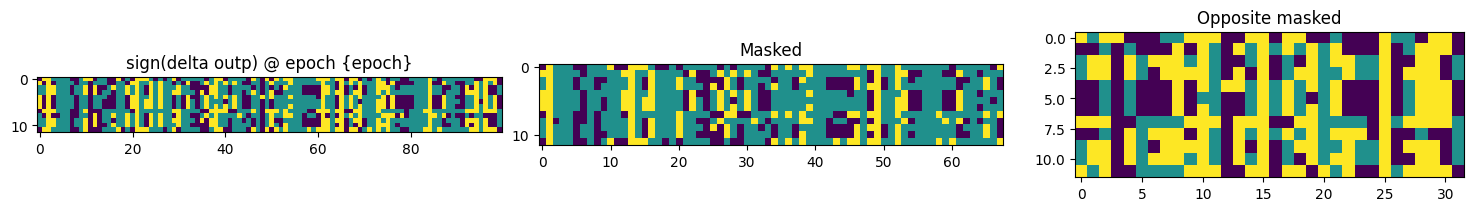

full:   (12, 100) - range -1.0 .. 1.0, nans: 0, mean: 0.008333333767950535
masked: (12, 68) - range -1.0 .. 1.0, nans: 0, mean: -0.006127451080828905
opp.:   (12, 32) - range -1.0 .. 1.0, nans: 0, mean: 0.0390625


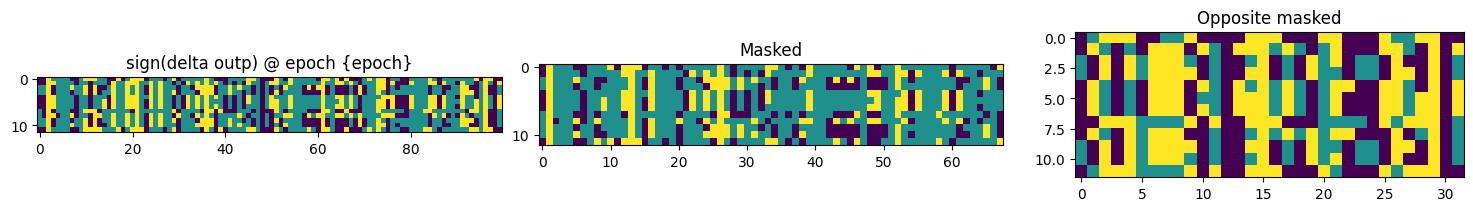

full:   (12, 100) - range -1.0 .. 1.0, nans: 0, mean: 0.04500000178813934
masked: (12, 68) - range -1.0 .. 1.0, nans: 0, mean: 0.03553921729326248
opp.:   (12, 32) - range -1.0 .. 1.0, nans: 0, mean: 0.0651041641831398


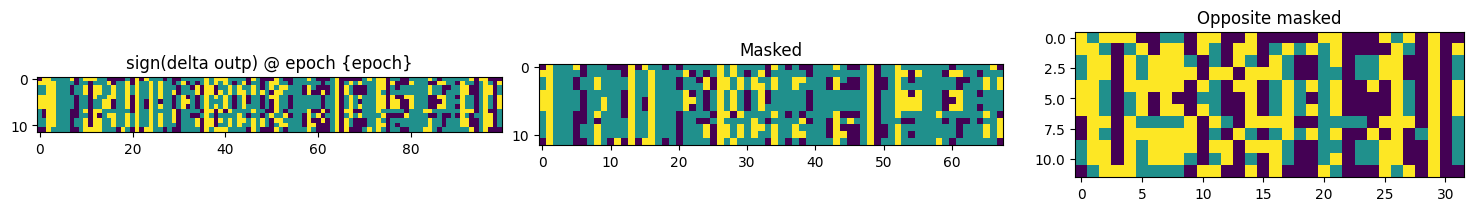

full:   (12, 100) - range -1.0 .. 1.0, nans: 0, mean: 0.05666666850447655
masked: (12, 68) - range -1.0 .. 1.0, nans: 0, mean: 0.04289215803146362
opp.:   (12, 32) - range -1.0 .. 1.0, nans: 0, mean: 0.0859375


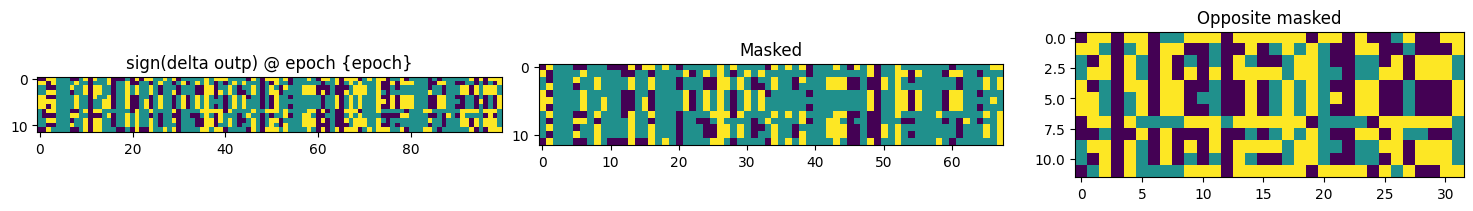

full:   (12, 100) - range -1.0 .. 1.0, nans: 0, mean: -0.021666666492819786
masked: (12, 68) - range -1.0 .. 1.0, nans: 0, mean: -0.04289215803146362
opp.:   (12, 32) - range -1.0 .. 1.0, nans: 0, mean: 0.0234375


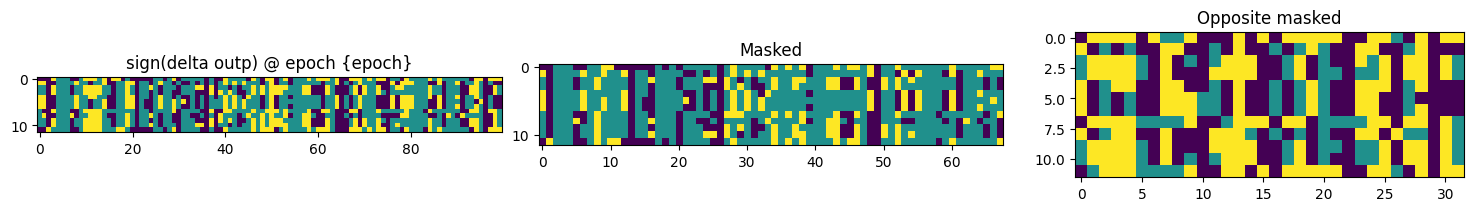

full:   (12, 100) - range -1.0 .. 1.0, nans: 0, mean: 0.02250000089406967
masked: (12, 68) - range -1.0 .. 1.0, nans: 0, mean: -0.026960784569382668
opp.:   (12, 32) - range -1.0 .. 1.0, nans: 0, mean: 0.1276041716337204


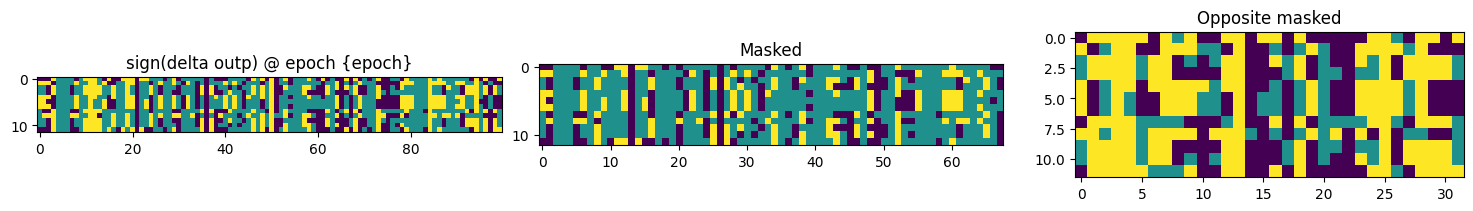

full:   (12, 100) - range -1.0 .. 1.0, nans: 0, mean: -0.0033333334140479565
masked: (12, 68) - range -1.0 .. 1.0, nans: 0, mean: -0.022058824077248573
opp.:   (12, 32) - range -1.0 .. 1.0, nans: 0, mean: 0.0364583320915699


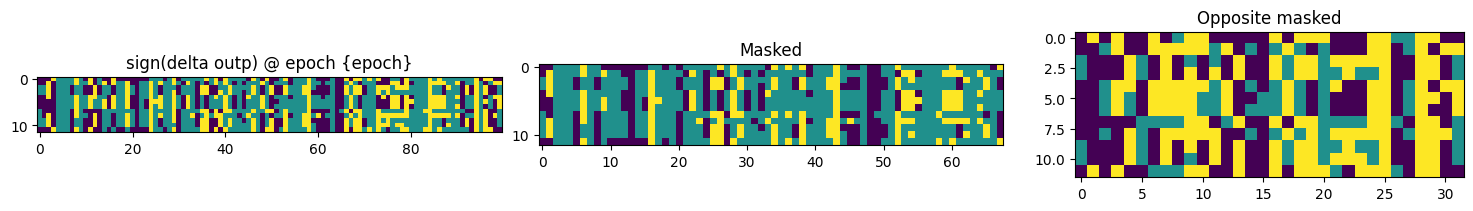

In [29]:
# There appears to be a trend that the "opposite masked" delta-outp have a) a lot of churn, and b) slightly more positive average,
# whereas the "masked" delta-outp is just a little negative....not lots...just a little.
# Let's confirm that over a few epochs.
outpN = outputs.layer_outputs[1][epochN]
m = dead_mask(outpN)
for epoch in range(1, 10):
  outp = outputs.layer_outputs[1][epoch]
  d_outp = outp - outputs.layer_outputs[1][epoch-1]
  plot_imshow_triple_masked(np.sign(d_outp), m, title="sign(delta outp) @ epoch {epoch}")

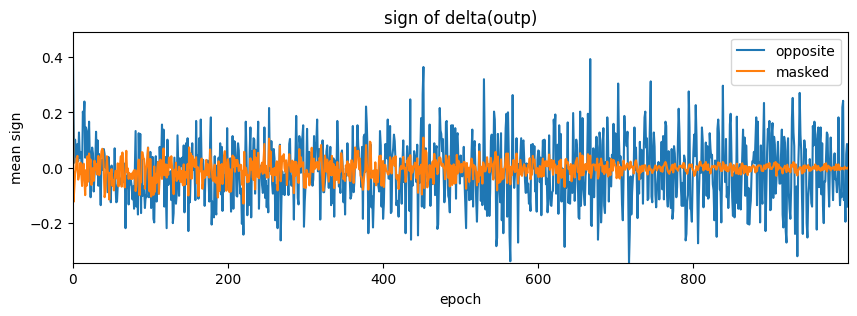

In [39]:
outpN = outputs.layer_outputs[1][epochN]
m = dead_mask(outpN)
masked_mean_signs = []
opp_mean_signs = []
for epoch in outputs.epochs:
  outp = outputs.layer_outputs[1][epoch]
  d_outp = np.array(outp - outputs.layer_outputs[1][epoch-1])

  masked_mean_signs.append(np.mean(np.sign(d_outp[:,m])))
  opp_mean_signs.append(np.mean(np.sign(d_outp[:,np.invert(m)])))

plt.figure(figsize=(10,3))
plt.title("sign of delta(outp)")
plt.plot(opp_mean_signs, label="opposite")
plt.plot(masked_mean_signs, label="masked")
plt.ylabel("mean sign")
plt.xlabel("epoch")
plt.margins(0)
plt.legend()
plt.show()

Discussion:
* Both series hover around 0.0.
* The magnitude of the masked series attenuates towards zero. This will be because the outp values get closer and closer to the final epoch output (outpN) that's being used as the reference mask, leaving fewer and fewer non-zero values in `d_outp`.
* So this is all pretty predictable and apparently uninteresting.
* What remains is to find _any_ strong signal for the fact that `outp` increases in number of dead neurons over that period. It's quite bizarre that we can't even see this in `d_outp`.

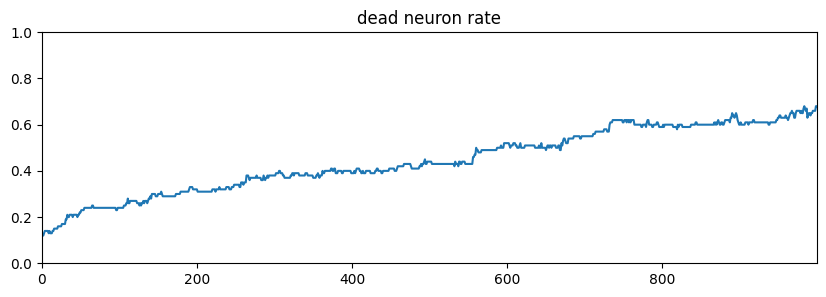

In [38]:
# Proving that we can at least see the dead neuron count
outpN = outputs.layer_outputs[1][epochN]
m = dead_mask(outpN)
dead_rates = []
for epoch in outputs.epochs:
  outp = outputs.layer_outputs[1][epoch]
  dead = np.sum(np.array(outp) != 0.0, axis=0) == 0
  dead_rates.append(np.sum(dead) / np.size(dead))

plt.figure(figsize=(10,3))
plt.title("dead neuron rate")
plt.plot(dead_rates)
plt.margins(0)
plt.ylim([0., 1.])
plt.show()

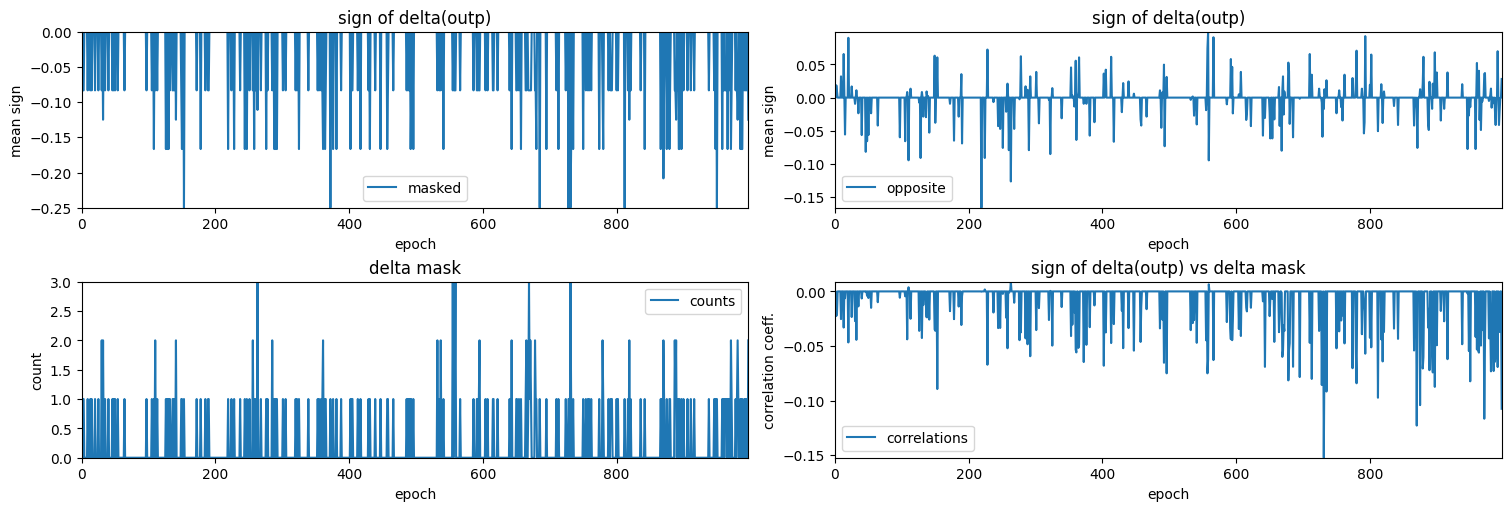

In [86]:
# using each epoch as its own mask
masked_mean_signs = []
opp_mean_signs = []
counts = []
corrs = []
for epoch in range(1, len(outputs.epochs)-1):
  outp = outputs.layer_outputs[1][epoch]
  d_outp = np.array(outp - outputs.layer_outputs[1][epoch-1])

  #m1 = dead_mask(outp)
  #m2 = dead_mask(outputs.layer_outputs[1][epoch-1])
  #m = np.any([m1, m2], axis=0)
  #m = dead_mask(outputs.layer_outputs[1][epoch+1])
  m = dead_mask(outputs.layer_outputs[1][epoch]).astype(np.float16) - dead_mask(outputs.layer_outputs[1][epoch-1]).astype(np.float16)
  m = m > 0

  counts.append(np.sum(m))
  if np.sum(m) > 0:
    c = corr(np.mean(np.sign(d_outp), axis=0), m.astype(np.float32))
    corrs.append(c)
    masked_mean_signs.append(np.mean(np.sign(d_outp[:,m])))
    opp_mean_signs.append(np.mean(np.sign(d_outp[:,np.invert(m)])))
  else:
    corrs.append(0)
    masked_mean_signs.append(0.0)
    opp_mean_signs.append(0.0)

plt.figure(figsize=(15,5), layout='constrained')

plt.subplot(2,2,1)
plt.title("sign of delta(outp)")
plt.plot(masked_mean_signs, label="masked")
plt.ylabel("mean sign")
plt.xlabel("epoch")
plt.margins(0)
plt.legend()

plt.subplot(2,2,2)
plt.title("sign of delta(outp)")
plt.plot(opp_mean_signs, label="opposite")
plt.ylabel("mean sign")
plt.xlabel("epoch")
plt.margins(0)
plt.legend()

plt.subplot(2,2,3)
plt.title("delta mask")
plt.plot(counts, label="counts")
plt.ylabel("count")
plt.xlabel("epoch")
plt.margins(0)
plt.legend()

plt.subplot(2,2,4)
plt.title("sign of delta(outp) vs delta mask")
plt.plot(corrs, label="correlations")
plt.ylabel("correlation coeff.")
plt.xlabel("epoch")
plt.margins(0)
plt.legend()

plt.show()

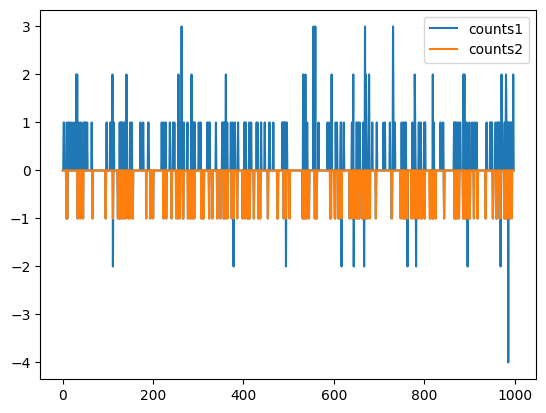

In [63]:
def dead_mask(t, axis=0):
  # default: assumes there's a batch dimension to reduce over
  return np.sum(np.abs(t), axis=axis) == 0.0

counts1 = []
counts2 = []
for epoch in range(1, len(outputs.epochs)):
  m = dead_mask(outputs.layer_outputs[1][epoch]).astype(np.float16) - dead_mask(outputs.layer_outputs[1][epoch-1]).astype(np.float16)
  counts1.append(np.sum(m))
  counts2.append(np.min(m))

plt.plot(counts1, label='counts1')
plt.plot(counts2, label='counts2')
plt.legend()
plt.show()

In [52]:
m

<tf.Tensor: shape=(12, 100), dtype=float32, numpy=
array([[-0.69931537, -1.0813762 , -0.52999085, ..., -0.40934685,
        -1.6654264 , -1.5190197 ],
       [-0.7041531 , -0.76048356, -1.5735294 , ...,  0.        ,
        -1.0828387 , -0.77645963],
       [ 0.        ,  0.        , -0.7795702 , ..., -1.2565491 ,
        -1.0532199 ,  0.        ],
       ...,
       [ 0.        ,  0.        , -0.8237391 , ..., -1.5063342 ,
        -1.2110175 ,  0.        ],
       [ 0.        ,  0.        , -0.6896229 , ..., -1.1604009 ,
        -0.9828134 ,  0.        ],
       [-0.5354111 , -0.7863768 , -0.58900106, ..., -0.731811  ,
        -1.3100241 , -0.85708785]], dtype=float32)>